In [ ]:
# ["transformers", "datasets", "accelerate", "sentencepiece", "seqeval"]
!python -m pip install transformers datasets accelerate sentencepiece seqeval

In [ ]:
from datasets import get_dataset_config_names
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


XTREME 서브셋 개수: 183


In [ ]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]

In [ ]:
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [ ]:
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, .229, .084, .59]
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )

In [ ]:
import pandas as pd

pd.DataFrame({
    lang: [panx_ch[lang]["train"].num_rows] for lang in langs
}, index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,11800


In [ ]:
element = panx_ch["de"]["train"][0]
for k, v in element.items():
    print(f"{k}: {v}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [ ]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [ ]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [ ]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [ ]:
from huggingface_hub import login
# login(token="_")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [ ]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
               labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,
                                        attentions=outputs.attentions)

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
             .from_pretrained(xlmr_model_name, config=xlmr_config)
             .to(device))
device

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [ ]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

In [ ]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
outputs

tensor([[[ 0.2414, -0.0942, -0.2792, -0.1095, -0.6333,  0.1679,  0.3493],
         [ 0.0948,  0.1287, -0.3519, -0.2837, -1.0685, -0.0287,  0.1957],
         [-0.0082,  0.1253, -0.3982, -0.3853, -0.9394, -0.0194,  0.2071],
         [-0.0067,  0.2001, -0.4349, -0.2206, -1.0909, -0.0468,  0.1937],
         [-0.0062,  0.2234, -0.3775, -0.2755, -1.1086, -0.0624,  0.2455],
         [ 0.0324,  0.2150, -0.2836, -0.1629, -1.0704, -0.0487,  0.2680],
         [ 0.0518,  0.2506, -0.3935, -0.2609, -1.1489, -0.0792,  0.2299],
         [ 0.0415,  0.2324, -0.3496, -0.2448, -1.0921, -0.0574,  0.2848],
         [ 0.0721,  0.1609, -0.2971, -0.2262, -1.0891, -0.1019,  0.3206],
         [ 0.1906, -0.1104, -0.3304, -0.0727, -0.6378,  0.1787,  0.3397]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"츨력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
츨력 크기: torch.Size([1, 10, 7])


In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,B-PER,I-LOC,I-LOC,B-PER,I-LOC,I-LOC,I-LOC


In [ ]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


In [ ]:
words, labels = de_example["tokens"], de_example["ner_tags"]
words

['2.000',
 'Einwohnern',
 'an',
 'der',
 'Danziger',
 'Bucht',
 'in',
 'der',
 'polnischen',
 'Woiwodschaft',
 'Pommern',
 '.']

In [ ]:
labels

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

In [ ]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [ ]:
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                     is_split_into_words=True)
    labels =[]
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                     remove_columns=["langs", "ner_tags", "tokens"])

In [ ]:
pd.DataFrame(panx_ch["de"]["train"][:10])

,tokens,ner_tags,langs
0,"[2.000, Einwohnern, an, der, Danziger, Bucht, ...","[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]","[de, de, de, de, de, de, de, de, de, de, de, de]"
1,"[Sie, geht, hinter, Walluf, nahtlos, in, die, ...","[0, 0, 0, 3, 0, 0, 0, 3, 4, 0, 0]","[de, de, de, de, de, de, de, de, de, de, de]"
2,"[Dirigenten, von, Weltruf, wie, Wilhelm, Furtw...","[0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, ...","[de, de, de, de, de, de, de, de, de, de, de, d..."
3,"[', '', Stade, Reims, '', ']","[0, 0, 3, 4, 0, 0]","[de, de, de, de, de, de]"
4,"[2011, David, J., P., Barker]","[0, 1, 2, 2, 2]","[de, de, de, de, de]"
5,"[Sie, liegt, in, der, Metropolregion, Chicago,...","[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]","[de, de, de, de, de, de, de, de, de, de, de, d..."
6,"[Anschließend, wurde, er, ins, KZ, Sachsenhaus...","[0, 0, 0, 0, 3, 4, 0, 0]","[de, de, de, de, de, de, de, de]"
7,"[==, Erfolge, in, der, UCI, America, Tour, ==]","[0, 3, 4, 4, 4, 4, 4, 0]","[de, de, de, de, de, de, de, de]"
8,"[Er, liegt, im, Landkreis, Ostallgäu, ,, dabei...","[0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]","[de, de, de, de, de, de, de, de, de, de, de, d..."
9,"[Fabian, Gottlieb, von, Bellingshausen]","[1, 2, 2, 2]","[de, de, de, de]"


In [ ]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
         ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC","I-MISC", "O"],
         ["B-PER", "I-PER", "O"]]

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list =[], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []

    for seq_idx in range(seq_len):
      if label_ids[batch_idx, seq_idx] != -100:
          example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
          example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

In [ ]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuened-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6,weight_decay=.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.252200,0.155188,0.819741
2,0.128800,0.147551,0.848660
3,0.078300,0.141695,0.869020


TrainOutput(global_step=2361, training_loss=0.153064905902886, metrics={'train_runtime': 170.3988, 'train_samples_per_second': 221.48, 'train_steps_per_second': 13.856, 'total_flos': 792244708985400.0, 'train_loss': 0.153064905902886, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

events.out.tfevents.1718948429.24beb714af6c.7249.1:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1718948223.24beb714af6c.7249.0:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

Upload 11 LFS files:   0%|          | 0/11 [00:00<?, ?it/s]

events.out.tfevents.1718948566.24beb714af6c.7249.3:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

events.out.tfevents.1718948505.24beb714af6c.7249.2:   0%|          | 0.00/7.10k [00:00<?, ?B/s]

events.out.tfevents.1718948781.24beb714af6c.7249.4:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

events.out.tfevents.1718949508.24beb714af6c.7249.5:   0%|          | 0.00/7.09k [00:00<?, ?B/s]

events.out.tfevents.1718949521.24beb714af6c.7249.6:   0%|          | 0.00/7.09k [00:00<?, ?B/s]

events.out.tfevents.1718949537.24beb714af6c.7249.7:   0%|          | 0.00/5.40k [00:00<?, ?B/s]

events.out.tfevents.1718949611.24beb714af6c.14008.0:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/blue2959/xlm-roberta-base-finetuened-panx-de/commit/ec460c21d1ac784531c3b763ef8163a80b55caf6', commit_message='Training complete', commit_description='', oid='ec460c21d1ac784531c3b763ef8163a80b55caf6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    output = trainer.model(input_ids, attention_mask)
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  loss = cross_entropy(output.logits.view(-1, 7),
                      labels.view(-1), reduction="none"
  )
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss": loss, "predicted_label": predicted_label}

In [ ]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()
df.head()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.0049646436, 0.0, 0.006856959, 0.005389...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00013267114, 0.0, 0.0, 0.0, 0.0, 1.528...","[0, 0, 0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00021181247, 0.000114076785, 0.0001344...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00021979777, 0.00015972769, 0.00017009...","[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00011801023, 0.00010203794, 0.00012265...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0049646436, 0.0, 0.006856959, 0.005389...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.00,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.53,B-PER,▁Luz
1,10,1,I-ORG,1.32,I-LOC,▁a


In [ ]:
(
 df_tokens.groupby("input_tokens")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="sum", ascending=False)
 .reset_index()
 .round(2)
 .head(10)
 .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁D,▁''
count,6066,1388,989,808,163,1171,246,246,89,2898
mean,0.03,0.11,0.15,0.16,0.55,0.08,0.28,0.28,0.65,0.02
sum,210.69,152.52,145.76,127.56,89.56,88.89,68.97,68.01,57.44,55.29


In [ ]:
(
 df_tokens.groupby("labels")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="mean", ascending=False)
 .reset_index()
 .round(2)
 .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.68,0.63,0.5,0.36,0.26,0.19,0.03
sum,998.76,1702.44,1893.97,1132.92,747.9,772.97,1419.2


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, lables):
  cm = confusion_matrix(y_true, y_preds, labels=lables, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
  disp.plot(cmap="Blues", values_format=".2f", ax = ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()


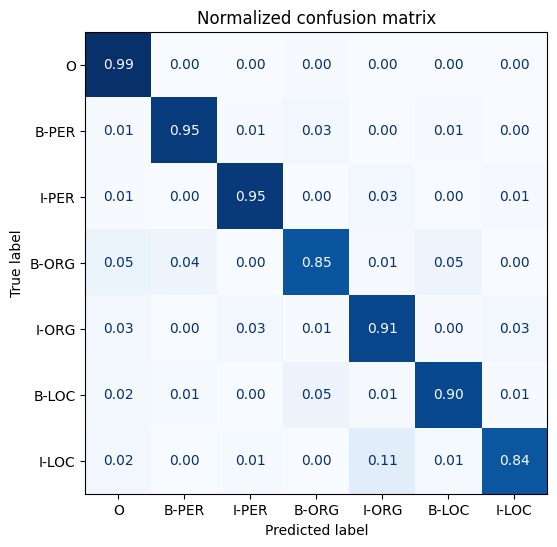

In [ ]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [ ]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention mask"]):
      if i not in {0, len(row["attention mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"labels": labels, "preds": preds, "tokens": tokens, "losses": losses}).T
    yield df_tmp

  df["total_loss"] = df["loss"].apply(sum)
  df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

  for sample in get_samples(df_tmp):
    display(sample)

In [ ]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
from collections import defaultdict
f1_scores = defaultdict(dict)

In [ ]:
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de]모델의 F1 점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de]모델의 F1 점수: 0.870


In [ ]:
text_fr = 'Jeff Dean est un informaticien à Google en Californie'
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens,<s>,▁Jeff,▁De,an,▁est,▁un,▁informatic,ien,▁à,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [ ]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])


In [ ]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[de] 데이터셋에서 [fr]모델의 F1 점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

[de] 데이터셋에서 [fr]모델의 F1 점수: 0.702


In [ ]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[de] 데이터셋에서 [it]모델의 F1 점수: {f1_scores['de']['it']:.3f}")

[de] 데이터셋에서 [it]모델의 F1 점수: 0.669


In [ ]:
f1_scores["de"]['en'] = evaluate_lang_performance("en", trainer)
print(f"[de] 데이터셋에서 [en]모델의 F1 점수: {f1_scores['de']['en']:.3f}")

[de] 데이터셋에서 [en]모델의 F1 점수: 0.590


In [ ]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds) // batch_size

  trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message="Training complete")
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict(
      {"num_samples": [len(train_ds)], "f1_score": [f1_score]}
  )

In [ ]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

In [ ]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.578400,1.229492,0.040680
2,1.132900,0.962587,0.257287
3,0.923000,0.855806,0.387694


,num_samples,f1_score
0,250,0.385108


In [ ]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)])
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.278900,0.771841,0.509226
2,0.653500,0.511552,0.670485
3,0.427300,0.455678,0.699837


Epoch,Training Loss,Validation Loss,F1
1,0.968000,0.482921,0.697788
2,0.415700,0.390043,0.756053
3,0.268000,0.371920,0.774215


Epoch,Training Loss,Validation Loss,F1
1,0.688300,0.398156,0.697741
2,0.308500,0.343972,0.792421
3,0.196600,0.348695,0.808801


Epoch,Training Loss,Validation Loss,F1
1,0.551000,0.379437,0.766517
2,0.261900,0.302363,0.833221
3,0.165100,0.278318,0.845288


,num_samples,f1_score
0,250,0.385108
0,500,0.701267
0,1000,0.780341
0,2000,0.816041
0,4000,0.847436


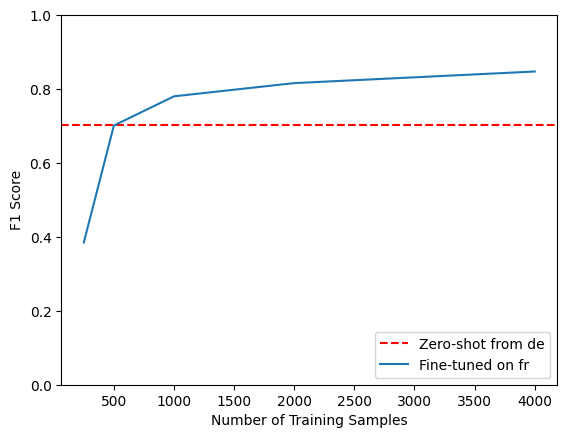

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim(0, 1)
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = f"{xlmr_model_name}-finetuened-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training complete")

Epoch,Training Loss,Validation Loss,F1
1,0.288100,0.184989,0.824327
2,0.149600,0.162337,0.848296
3,0.094800,0.170563,0.860999


training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/blue2959/xlm-roberta-base-finetuened-panx-de-fr/commit/da8ed2399ece569efc77ddad4a788c4f0f42c1b1', commit_message='Training complete', commit_description='', oid='da8ed2399ece569efc77ddad4a788c4f0f42c1b1', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"[{lang}] 데이터셋에서 [de-fr]모델의 F1 점수: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

[de] 데이터셋에서 [de-fr]모델의 F1 점수: 0.864


[fr] 데이터셋에서 [de-fr]모델의 F1 점수: 0.859


[it] 데이터셋에서 [de-fr]모델의 F1 점수: 0.794


[en] 데이터셋에서 [de-fr]모델의 F1 점수: 0.676


In [ ]:
corpora = [panx_de_encoded]

for lang in langs[1:]:
  training_args.output_dir = f"{xlmr_model_name}-finetuened-panx-de-{lang}"
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  f1_scores[lang][lang] = metrics["f1_score"][0]
  corpora.append(ds_encoded)


Epoch,Training Loss,Validation Loss,F1
1,0.531700,0.315296,0.802721
2,0.257800,0.286544,0.820771
3,0.167100,0.299917,0.848577


training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.614300,0.335509,0.732642
2,0.243500,0.264376,0.809291
3,0.153800,0.262765,0.834225


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.443500,0.306897,0.772203
2,0.259500,0.284960,0.794763
3,0.180300,0.272539,0.809484


training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size

In [ ]:
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.312300,0.220974,0.807063
2,0.183800,0.198709,0.831075
3,0.123200,0.208475,0.844694


training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/blue2959/xlm-roberta-base-finetuned-panx-all/commit/58461d11a87c3319422fd2e7d00b3d70e283f57e', commit_message='Training completed!', commit_description='', oid='58461d11a87c3319422fd2e7d00b3d70e283f57e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all" : f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis("Fine-tune on", columns="Evaluated on", inplace=True)
f1_scores_df

,de,fr,it,en
Fine-tune on,,,,
de,0.8699,0.7021,0.6689,0.5904
each,0.8699,0.8482,0.8289,0.8073
all,0.8672,0.8687,0.8746,0.8168
